# Projek Capstone: Dashboard Analisis Penjualan UMKM Fashion Untuk Mengidentifikasi Tren Konsumen dan Strategi Optimasi Pendapatan

**List Anggota :**
1. B244035E - Adilah Widiasti – Aktif
2. B244010E - I Gusti Bagus Ramadha Saverian Ranuh – Aktif
3. B244012E - Muhammad Adib – Aktif
4. B244003E - Zefanya Danovanta Tarigan – Aktif


# Preparation

In [ ]:
!pip install opendatasets

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505171 sha256=f2531e713ba472b2de02ff6123b02f6f242346d72ccb8eff7b83669f0691ea72
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


## Import Library and Package

In [ ]:
# Untuk Data Manipulation and Analysis
import numpy as np
import pandas as pd
from datetime import datetime

# Untuk Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.cluster import KElbowVisualizer

# Untuk Machine Learning and Model Evaluation
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, r2_score, classification_report,
                             accuracy_score, confusion_matrix, mean_absolute_percentage_error)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

# Untuk Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Untuk Time Series Analysis
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Untuk Recommendation Systems
from surprise import Dataset, Reader, SVD, accuracy

# Untuk Utilities
import joblib
import opendatasets as od

# Data Wrangling

## Gathering Data

In [ ]:
# Gunakan: {"username":"rmrnh177","key":"8079f9b52b8cc27fc9c55aeb547605f7"}

In [ ]:
od.download('https://www.kaggle.com/datasets/fekihmea/fashion-retail-sales/data?select=Fashion_Retail_Sales.csv')

df = pd.read_csv('/content/fashion-retail-sales/Fashion_Retail_Sales.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rmrnh177
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/fekihmea/fashion-retail-sales


100%|██████████| 31.8k/31.8k [00:00<00:00, 13.2MB/s]

In [ ]:
df.head()

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
0,4018,Handbag,4619.0,2023-02-05,NaN,Credit Card
1,4115,Tunic,2456.0,2023-07-11,2.0,Credit Card
2,4019,Tank Top,2102.0,2023-03-23,4.1,Cash
3,4097,Leggings,3126.0,2023-03-15,3.2,Cash
4,3997,Wallet,3003.0,2022-11-27,4.7,Cash


## Assessing Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer Reference ID  3400 non-null   int64  
 1   Item Purchased         3400 non-null   object 
 2   Purchase Amount (USD)  2750 non-null   float64
 3   Date Purchase          3400 non-null   object 
 4   Review Rating          3076 non-null   float64
 5   Payment Method         3400 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 159.5+ KB


**Insight**: Berdasarkan hasil tinjauan informasi stuktur dataset di atas, dapat disimpulkan bahwa dataset ini memiliki total 6 kolom dan 3400 baris. Kolom `Purchase Amount (USD)` dan `Review Rating` tampak memiliki jumlah baris kurang dari 3.400. Secara sederhana, hal ini menunjukkan bahwa terdapat beberapa nilai yang hilang (missing value) dalam kedua kolom tersebut.

Untuk memastikannya, kita dapat menggunakan method `isnull()` yang dikombinasikan dengan method `sum()` untuk melihat jumlah nilai yang hilang di setiap kolom dari dataset ini.

In [ ]:
df_summary = pd.DataFrame({'Data Type': df.dtypes,
                                  'Non-Null Count': df.count(),
                                  'Missing Values': df.isnull().sum()},
                                  )
df_summary

,Data Type,Non-Null Count,Missing Values
Customer Reference ID,int64,3400,0
Item Purchased,object,3400,0
Purchase Amount (USD),float64,2750,650
Date Purchase,object,3400,0
Review Rating,float64,3076,324
Payment Method,object,3400,0


**Insight**:
- Kolom `Purchase Amount (USD)` memiliki 650 missing value.
- Kolom `Review Rating` memiliki 324 missing value.

In [ ]:
df.duplicated().sum()

0

**Insight:** Berdasarkan hasil pemeriksaan duplikasi data di atas, dapat disimpulkan bahwa tidak terdapat data yang terduplikasi dalam dataset ini.

In [ ]:
column_names = df.keys().values.tolist()
column_names

['Customer Reference ID',
 'Item Purchased',
 'Purchase Amount (USD)',
 'Date Purchase',
 'Review Rating',
 'Payment Method']

## Data Cleaning

### Mengatasi Missing Value

In [ ]:
# Drop kolom dengan purchase amount NULL (lebih reccomended di drop saja karena tidak terlalu berpengaruh terhadap generalisasi)
df = df.dropna(subset=['Purchase Amount (USD)'])

In [ ]:
# Ganti kolom review rating NULL dengan average (lebih reccomended diganti avg agar tidak kehilangan generalisasi)
average_rating = df['Review Rating'].mean()
df['Review Rating'] = df['Review Rating'].fillna(average_rating)

<ipython-input-12-0a46a19411c9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review Rating'] = df['Review Rating'].fillna(average_rating)


In [ ]:
df.isna().sum()

,0
Customer Reference ID,0
Item Purchased,0
Purchase Amount (USD),0
Date Purchase,0
Review Rating,0
Payment Method,0


### Mengatasi Outlier

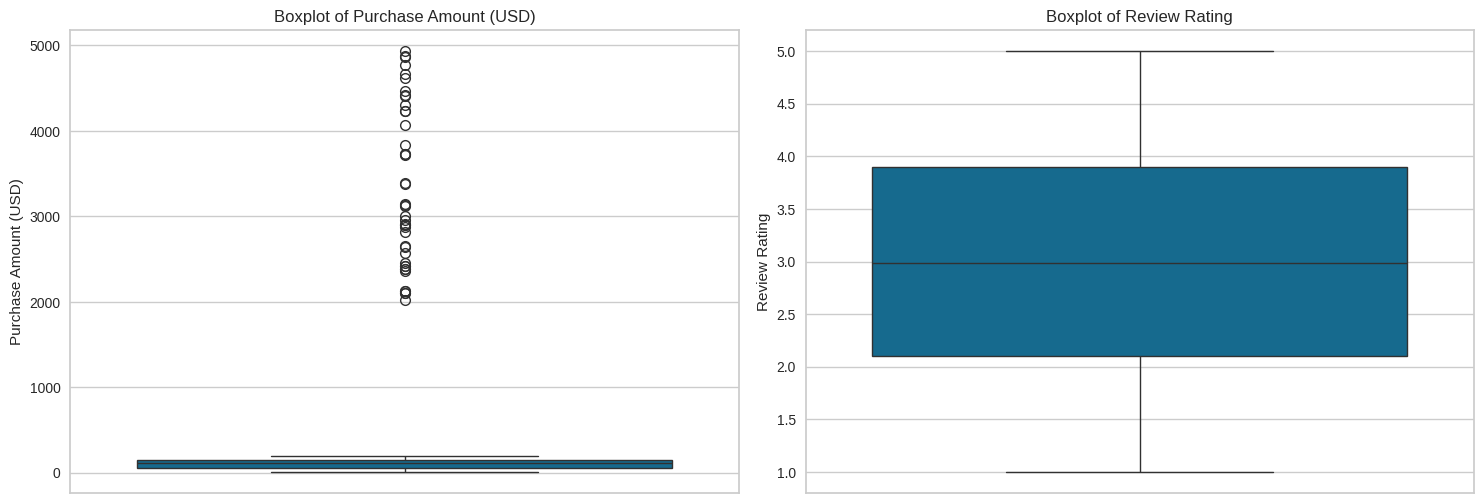

In [ ]:
numerical_features = ['Purchase Amount (USD)', 'Review Rating']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [ ]:
def find_outliers_IQR(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [ ]:
outliers_purchase_amount = find_outliers_IQR(df, 'Purchase Amount (USD)')
print("Outliers in Purchase Amount (USD):")
print(outliers_purchase_amount)

Outliers in Purchase Amount (USD):
    Customer Reference ID Item Purchased  Purchase Amount (USD) Date Purchase  \
0                    4018        Handbag                 4619.0    2023-02-05   
1                    4115          Tunic                 2456.0    2023-07-11   
2                    4019       Tank Top                 2102.0    2023-03-23   
3                    4097       Leggings                 3126.0    2023-03-15   
4                    3997         Wallet                 3003.0    2022-11-27   
5                    4080         Onesie                 2914.0    2022-12-11   
6                    4055         Jacket                 2571.0    2023-07-08   
7                    3973       Trousers                 2419.0    2022-11-10   
8                    4044          Jeans                 4771.0    2023-05-19   
9                    4010        Loafers                 4233.0    2023-06-11   
10                   4108       Slippers                 2356.0    2023-03

In [ ]:
mean = df['Purchase Amount (USD)'].mean()
std = df['Purchase Amount (USD)'].std()

lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

outliers = df[(df['Purchase Amount (USD)'] < lower_bound) | (df['Purchase Amount (USD)'] > upper_bound)]

In [ ]:
df = df[(df['Purchase Amount (USD)'] >= lower_bound) & (df['Purchase Amount (USD)'] <= upper_bound)]

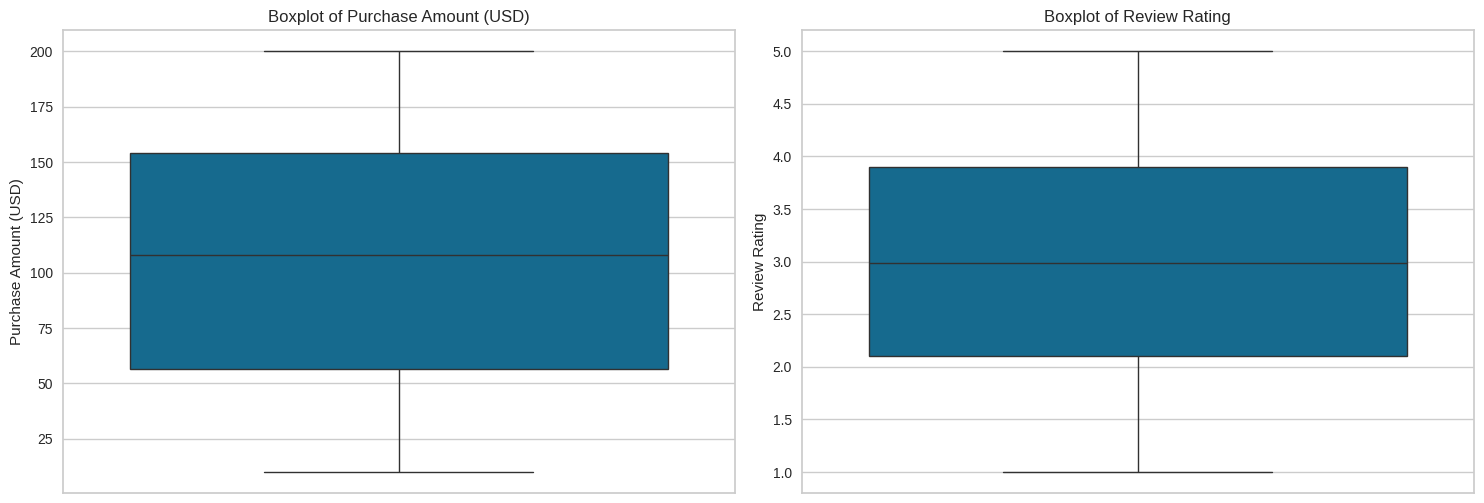

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

**Insight:** Berdasarkan hasil penanganan outlier di atas, dapat terlihat bahwa sudah tidak terdapat lagi titik-titik data yang berada di luar ambang batas atas dan ambang batas bawah. Hal tersebut menunjukkan bahwa outlier sudah ditangani atau tidak ada lagi di dalam dataset

## Change Datetime

In [ ]:
df['Date Purchase'] = pd.to_datetime(df['Date Purchase'])

In [ ]:
df.sort_values('Date Purchase', inplace=True)

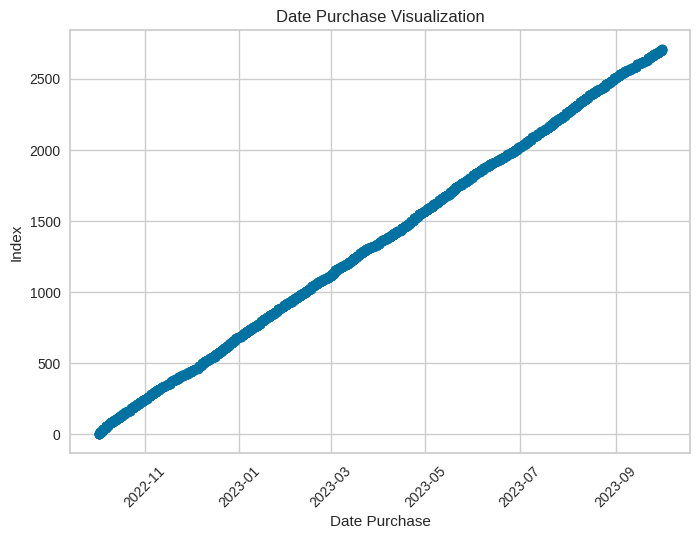

In [ ]:
plt.plot(df['Date Purchase'], range(df.shape[0]), marker='o')
plt.xlabel('Date Purchase')
plt.ylabel('Index')
plt.title('Date Purchase Visualization')

plt.xticks(rotation=45)

plt.show()

# Exploratory Data Analysis

In [ ]:
df.describe()

,Customer Reference ID,Purchase Amount (USD),Review Rating
count,3400.000000,2750.000000,3076.000000
mean,4039.660588,156.709818,2.999057
std,48.122583,419.536669,1.156505
min,3957.000000,10.000000,1.000000
25%,3997.000000,57.000000,2.000000
50%,4040.000000,110.000000,3.000000
75%,4081.000000,155.750000,4.000000
max,4122.000000,4932.000000,5.000000


**Insight:**

Berdasarkan hasil pemeriksaan parameter statistik di atas, dapat disimpulkan bahwa:
- Fitur `Purchase Amount (USD)` memiliki nilai rata-rata 156. Hal tersebut menunjukkan bahwa rata-rata jumlah pembelian para pelanggan adalah `$156`. Adapun jumlah terendahnya adalah `$10` sedangkan jumlah tertingginya adalah `$4932`.
- Fitur `Review Rating` memiliki nilai rata-rata 2,9. Hal tersebut menunjukkan bahwa rata-rata nilai ulasan yang diberikan pelanggan adalah 2,9. Adapun nilai ulasan tertingginya adalah 5 sedangkan nilai ulasan terendahnya adalah 1.

In [ ]:
df['Customer Reference ID'].duplicated().sum()

2541

In [ ]:
df['Customer Reference ID'].value_counts()

,count
Customer Reference ID,
4078,28
4122,27
4075,24
3973,24
4065,24
...,...
4101,8
4046,8
4112,7


In [ ]:
value_counts = df['Item Purchased'].value_counts()
value_counts.head(10)

,count
Item Purchased,
Shorts,73
Pants,70
Skirt,70
Belt,68
Tank Top,65
T-shirt,62
Camisole,62
Hoodie,61
Kimono,60


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=value_counts.values,
    y=value_counts.index,
    orientation='h',
    marker=dict(
        color=value_counts.values,
        colorscale=['lightsteelblue', 'navy'],
        showscale=True
    )
))

# Update layout
fig.update_layout(
    title={
        'text': 'Item Purchased Counts',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Count',
    yaxis_title='Items',
    plot_bgcolor='white',
    bargap=0.2,
    showlegend=False
)

# Update axes
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=False)

# Display the chart
fig.show()

**Insight:** Berdasarkan hasil eksplorasi fitur `Item Purchased` di atas, dapat disimpulkan bahwa celana pendek (shorts) merupakan produk yang paling banyak dibeli sedangkan celana panjang (trousers) merupakan produk yang paling sedikit dibeli

In [ ]:
fig = px.histogram(df, x='Review Rating', nbins=6, title='Distribution of Review Ratings')
fig.update_layout(
    xaxis_title='Rating',
    yaxis_title='Frequency',
    template='plotly_dark'
)

fig.update_traces(marker=dict(color='turquoise'))

fig.show()

**Insight:** Berdasarkan hasil tinjauan atas distribusi data dalam fitur `Review Ratings` di atas, dapat disimpulkan bahwa data ini memiliki distribusi data yang simetris dengan angka 3 sebagai pilihan rating yang paling banyak digunakan.

# Clustering

In [ ]:
df

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
1392,4025,Blouse,126.0,2022-10-02,1.5,Cash
2286,4108,Handbag,50.0,2022-10-02,2.1,Credit Card
1250,4008,Belt,130.0,2022-10-02,3.4,Credit Card
3302,4093,Handbag,24.0,2022-10-02,2.8,Credit Card
1704,4014,Tank Top,99.0,2022-10-02,1.2,Cash
...,...,...,...,...,...,...
1433,4108,Camisole,46.0,2023-10-01,1.8,Cash
1790,4029,Pajamas,151.0,2023-10-01,4.0,Cash
824,4005,Vest,122.0,2023-10-01,2.0,Cash
2944,4000,Wallet,58.0,2023-10-01,2.6,Credit Card


In [ ]:
data_encoder = df.copy()
# Get list of categorical variables
LE=LabelEncoder()
object_cols = df.select_dtypes(include=['object']).columns
for i in object_cols:
    data_encoder[i]=df[[i]].apply(LE.fit_transform)
print('All features are now numerical')
data_encoder.head()

All features are now numerical


,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
1392,4025,3,126.0,2022-10-02,1.5,0
2286,4108,13,50.0,2022-10-02,2.1,1
1250,4008,1,130.0,2022-10-02,3.4,1
3302,4093,13,24.0,2022-10-02,2.8,1
1704,4014,42,99.0,2022-10-02,1.2,0


In [ ]:
data_clustering=data_encoder[["Item Purchased","Purchase Amount (USD)","Review Rating","Payment Method"]]

scaler = StandardScaler()
scaler.fit(data_clustering)
scaled_features = pd.DataFrame(scaler.transform(data_clustering),columns= data_clustering.columns )
print('All features are now scalled')
scaled_features.head()

All features are now scalled


,Item Purchased,Purchase Amount (USD),Review Rating,Payment Method
0,-1.495009,0.356177,-1.354772,-1.045744
1,-0.801461,-1.019092,-0.805916,0.956257
2,-1.633718,0.428560,0.383271,0.956257
3,-0.801461,-1.489579,-0.165585,0.956257
4,1.209827,-0.132405,-1.629200,-1.045744


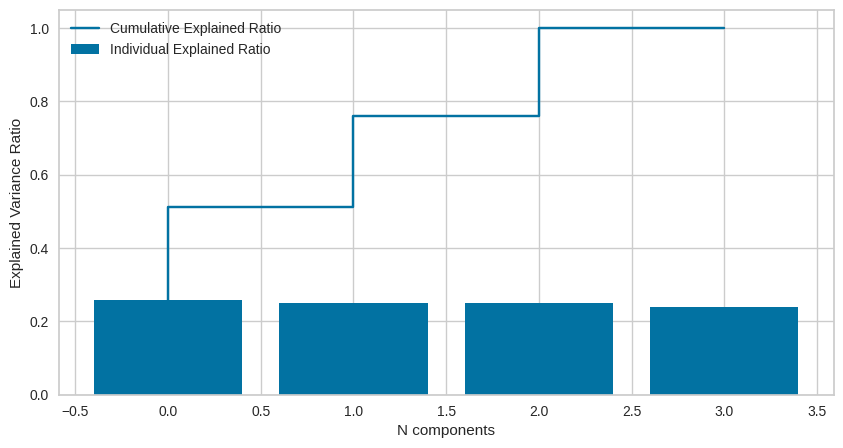

In [ ]:
pca = PCA()
pca.fit(scaled_features)
cum_sum_eigenvalues = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,5))
plt.bar(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, label="Individual Explained Ratio")
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, label="Cumulative Explained Ratio")
plt.xlabel("N components")
plt.ylabel("Explained Variance Ratio")
plt.legend(loc="best")
plt.show()

In [ ]:
cols = ["PCA1", "PCA2", "PCA3"]
pca = PCA(n_components=len(cols))
pca.fit(scaled_features)
PCA_df = pd.DataFrame(pca.transform(scaled_features), columns=(cols))
PCA_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PCA1,2707.0,5.249669e-18,1.018383,-2.947104,-0.706907,0.002164,0.729023,3.016773
PCA2,2707.0,-1.574901e-17,1.003174,-2.296275,-0.826541,0.030893,0.820057,2.347114
PCA3,2707.0,3.346664e-17,1.001815,-2.622492,-0.725420,-0.019397,0.694978,2.687192


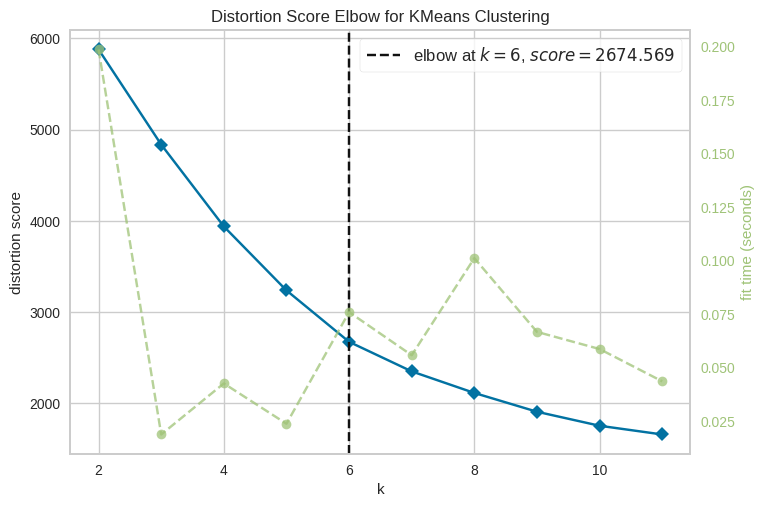

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=11)
visualizer.fit(PCA_df)
visualizer.show()

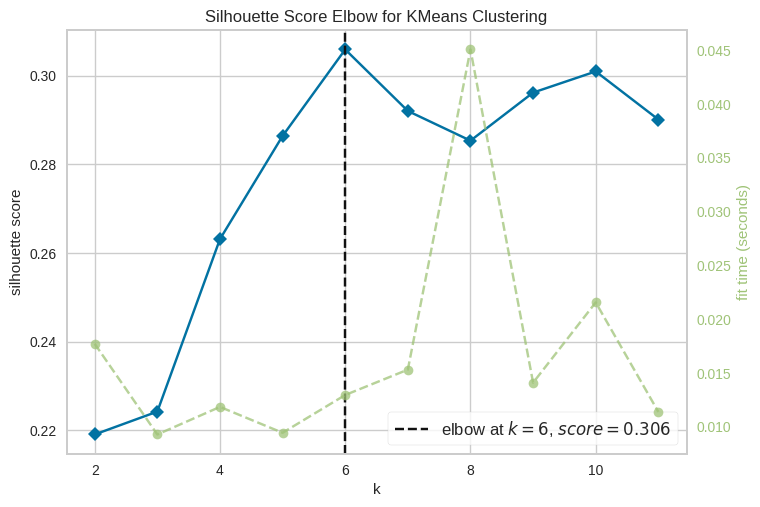

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=11, metric='silhouette')
visualizer.fit(PCA_df)
visualizer.show()

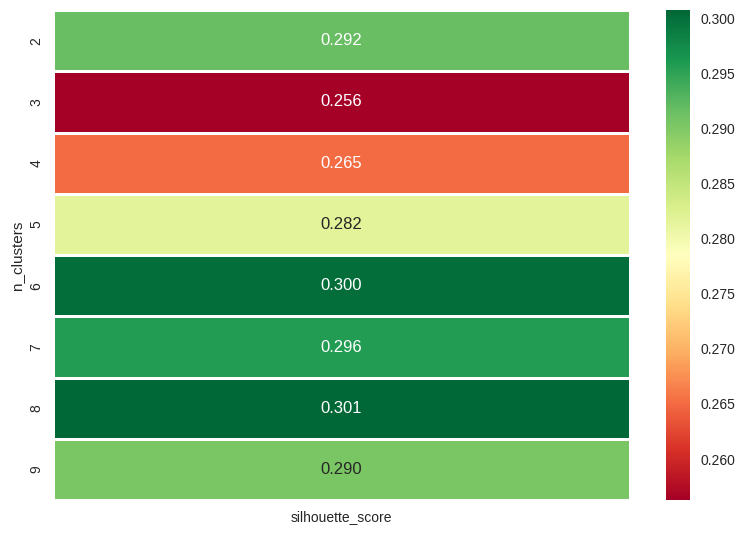

In [ ]:
from sklearn.metrics import silhouette_score
def visualize_silhouette_layer(data):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='RdYlGn')
    plt.tight_layout()
    plt.show()

visualize_silhouette_layer(PCA_df)

In [ ]:
nb_clusters = visualizer.elbow_value_
AC = AgglomerativeClustering(n_clusters=5)

# fit model and predict clusters
AC_df = AC.fit_predict(PCA_df)
PCA_df["Clusters"] = AC_df
# Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= AC_df

In [ ]:
df.head()

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method,Clusters
1392,4025,Blouse,126.0,2022-10-02,1.5,Cash,4
2286,4108,Handbag,50.0,2022-10-02,2.1,Credit Card,0
1250,4008,Belt,130.0,2022-10-02,3.4,Credit Card,0
3302,4093,Handbag,24.0,2022-10-02,2.8,Credit Card,0
1704,4014,Tank Top,99.0,2022-10-02,1.2,Cash,1


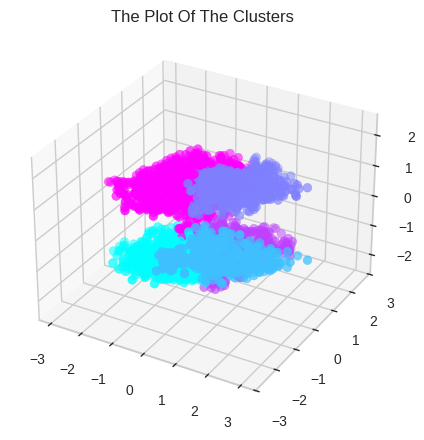

In [ ]:
x =PCA_df["PCA1"]
y =PCA_df["PCA3"]
z =PCA_df["PCA2"]
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df["Clusters"], marker='o', cmap = 'cool_r' )
ax.set_title("The Plot Of The Clusters")
plt.show()

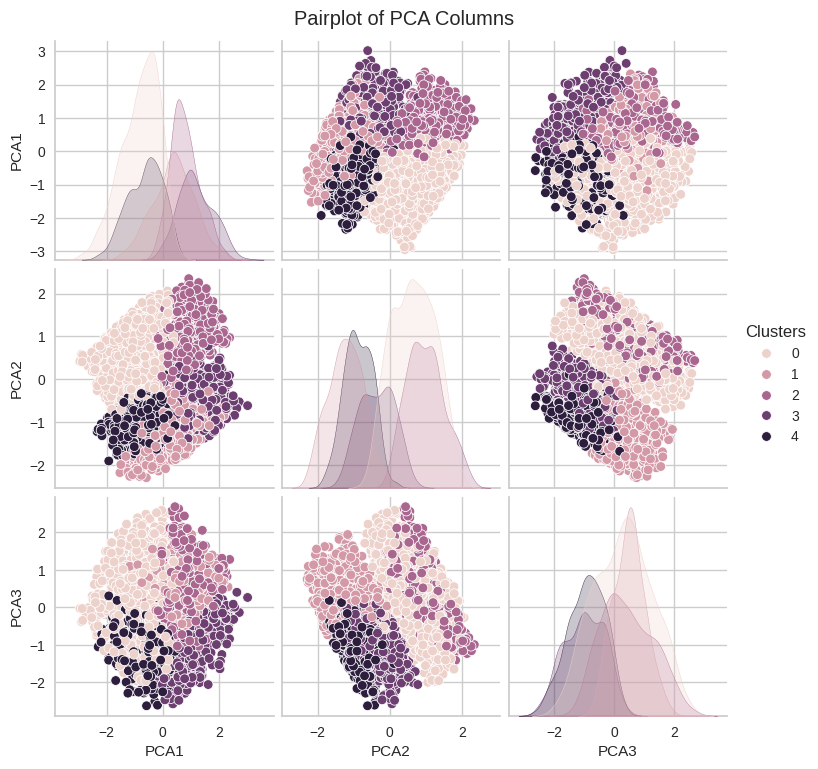

In [ ]:
sns.pairplot(data=PCA_df, vars=['PCA1', 'PCA2', 'PCA3'], hue='Clusters')
plt.suptitle("Pairplot of PCA Columns", y=1.02)
plt.show()

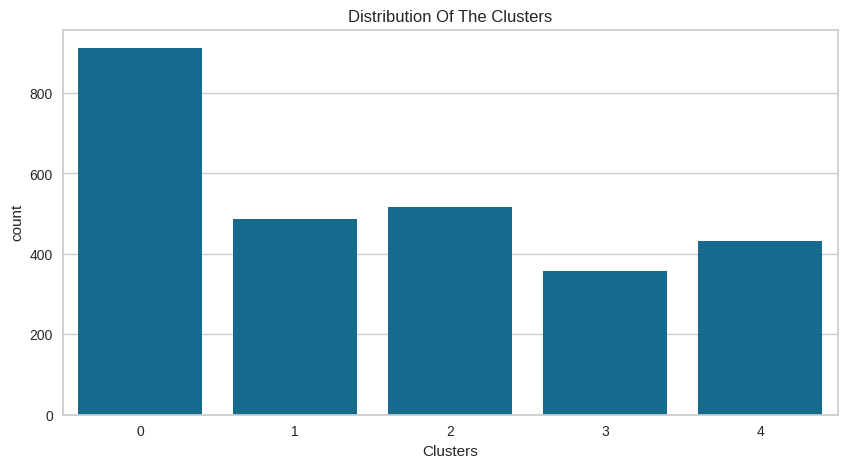

In [ ]:
fig = plt.figure(figsize=(10,5))
pl = sns.countplot(x=df["Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.show()

In [ ]:
df.head()

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method,Clusters
1392,4025,Blouse,126.0,2022-10-02,1.5,Cash,4
2286,4108,Handbag,50.0,2022-10-02,2.1,Credit Card,0
1250,4008,Belt,130.0,2022-10-02,3.4,Credit Card,0
3302,4093,Handbag,24.0,2022-10-02,2.8,Credit Card,0
1704,4014,Tank Top,99.0,2022-10-02,1.2,Cash,1


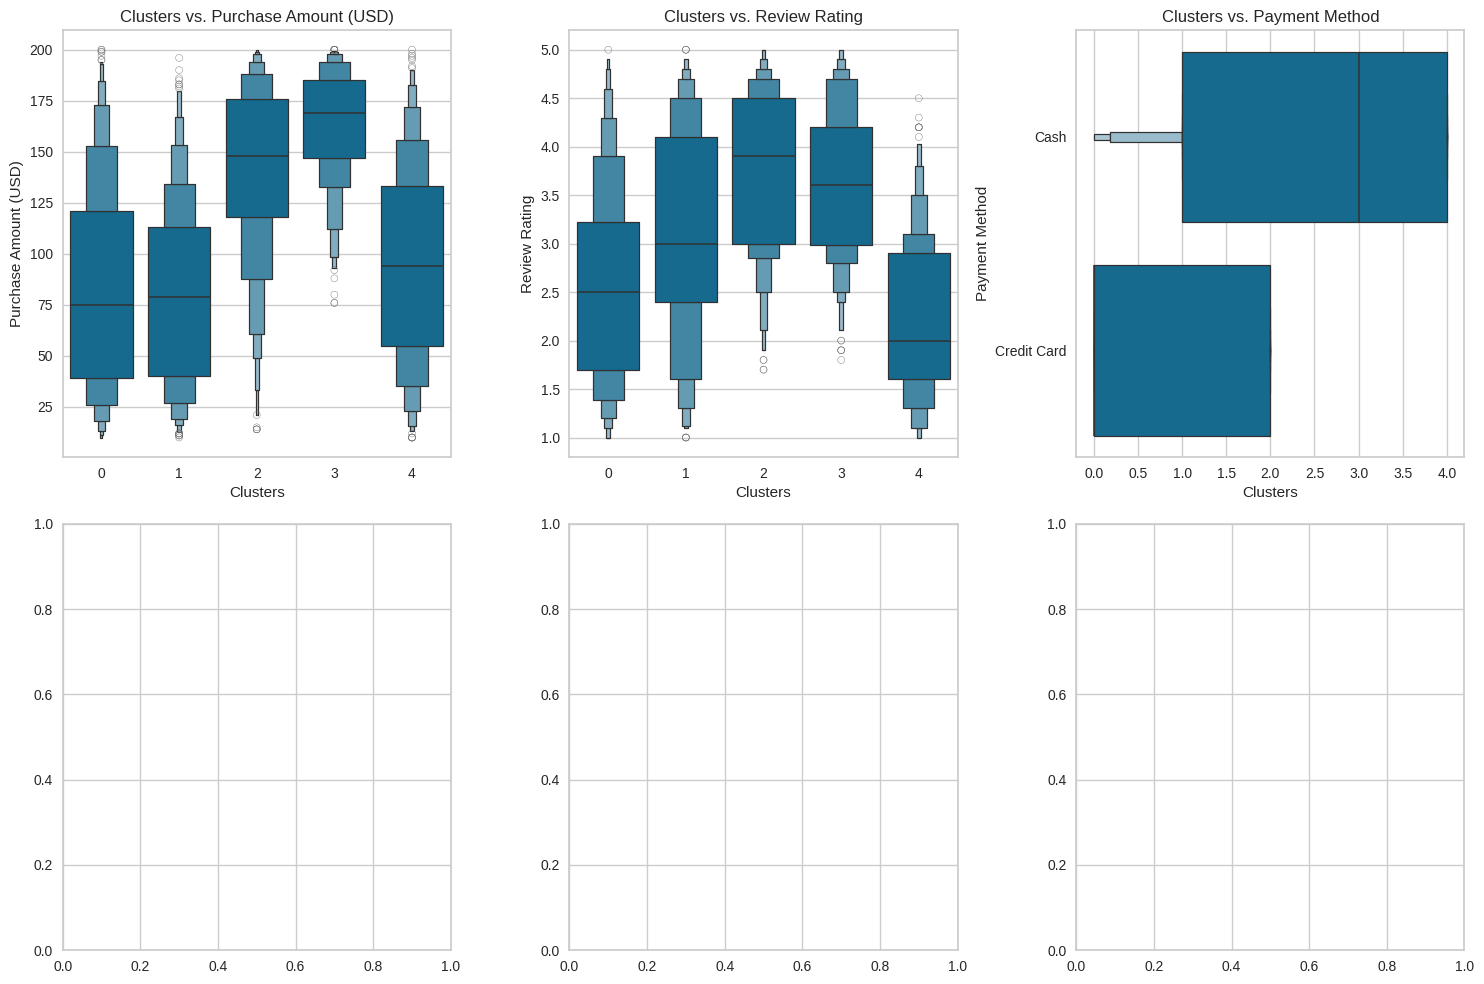

In [ ]:
columns=["Purchase Amount (USD)","Review Rating","Payment Method"]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, column in enumerate(columns):
    row = i // 3
    col = i % 3
    sns.boxenplot(x=df["Clusters"], y=df[column], ax=axes[row, col])
    axes[row, col].set_title(f'Clusters vs. {column}')

plt.tight_layout()
plt.show()

In [ ]:
seg_map = {
    r'[1-2][1-2]': 'Inactive Customer',
    r'[1-2][3-4]': 'Declining Customer',
    r'[1-2]5': 'High Value Low Engagement Customer',
    r'3[1-2]': 'Transation to Inactive Customer',
    r'33': 'Needed Attention Customer',
    r'[3-4][4-5]': 'Loyal Customer',
    r'41': 'Promising Customer',
    r'51': 'New Customer',
    r'[4-5][2-3]': 'Potential Loyal Customer',
    r'5[4-5]': 'Top Spending Customer'
}

In [ ]:
df.head()

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method,Clusters
1392,4025,Blouse,126.0,2022-10-02,1.5,Cash,4
2286,4108,Handbag,50.0,2022-10-02,2.1,Credit Card,0
1250,4008,Belt,130.0,2022-10-02,3.4,Credit Card,0
3302,4093,Handbag,24.0,2022-10-02,2.8,Credit Card,0
1704,4014,Tank Top,99.0,2022-10-02,1.2,Cash,1


In [ ]:
# Calculate Recency, Frequency, and Monetary
current_date = max(df['Date Purchase'])
rfm = df.groupby('Customer Reference ID').agg({
    'Date Purchase': lambda x: ((current_date - x.max()).days)/7,
    'Customer Reference ID': 'count',
    'Purchase Amount (USD)': 'sum'
})

rfm['Purchase Amount (USD)'] = (rfm['Purchase Amount (USD)'] / 7).astype(int)
# Rename columns to R, F, and M
rfm.rename(columns={
    'Date Purchase': 'Recency',
    'Customer Reference ID': 'Frequency',
    'Purchase Amount (USD)': 'Monetary'
}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
Customer Reference ID,,,
3957,12.142857,11,164
3958,2.428571,17,190
3959,6.857143,19,292
3960,2.428571,15,204
3961,4.714286,17,258


In [ ]:
def get_rfm_scores(data):
    data["R"] = pd.qcut(data["Recency"], 5, labels=[5, 4, 3, 2, 1])
    data["F"] = pd.qcut(data["Frequency"].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
    data["M"] = pd.qcut(data["Monetary"], 5, labels=[1, 2, 3, 4, 5])
    data["RFM_SCORE"] = data["R"].astype(str) + data["F"].astype(str)
    return data

get_rfm_scores(rfm)
rfm.reset_index()
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_SCORE,segment
Customer Reference ID,,,,,,,,
3957,12.142857,11,164,1,1,1,11,Inactive Customer
3958,2.428571,17,190,3,3,1,33,Needed Attention Customer
3959,6.857143,19,292,1,4,4,14,Declining Customer
3960,2.428571,15,204,3,2,2,32,Transation to Inactive Customer
3961,4.714286,17,258,2,3,3,23,Declining Customer


In [ ]:
df_cluster = rfm.copy()
x = df_cluster.segment.value_counts()
fig = px.treemap(x, path=[x.index], values=x, color=x.index)
fig.update_layout(title_text='Distribution of the RFM Segments', title_x=0.5,title_font=dict(size=40))
fig.update_traces(textinfo="label+value+percent root")
fig.show()

# Model Building

## Classification

### SVM

In [ ]:
df_cluster.head()

,Recency,Frequency,Monetary,R,F,M,RFM_SCORE,segment
Customer Reference ID,,,,,,,,
3957,12.142857,11,164,1,1,1,11,Inactive Customer
3958,2.428571,17,190,3,3,1,33,Needed Attention Customer
3959,6.857143,19,292,1,4,4,14,Declining Customer
3960,2.428571,15,204,3,2,2,32,Transation to Inactive Customer
3961,4.714286,17,258,2,3,3,23,Declining Customer


In [ ]:
X = df_cluster.drop('segment', axis=1)
y = df_cluster['segment']

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

In [ ]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34

Accuracy: 1.0


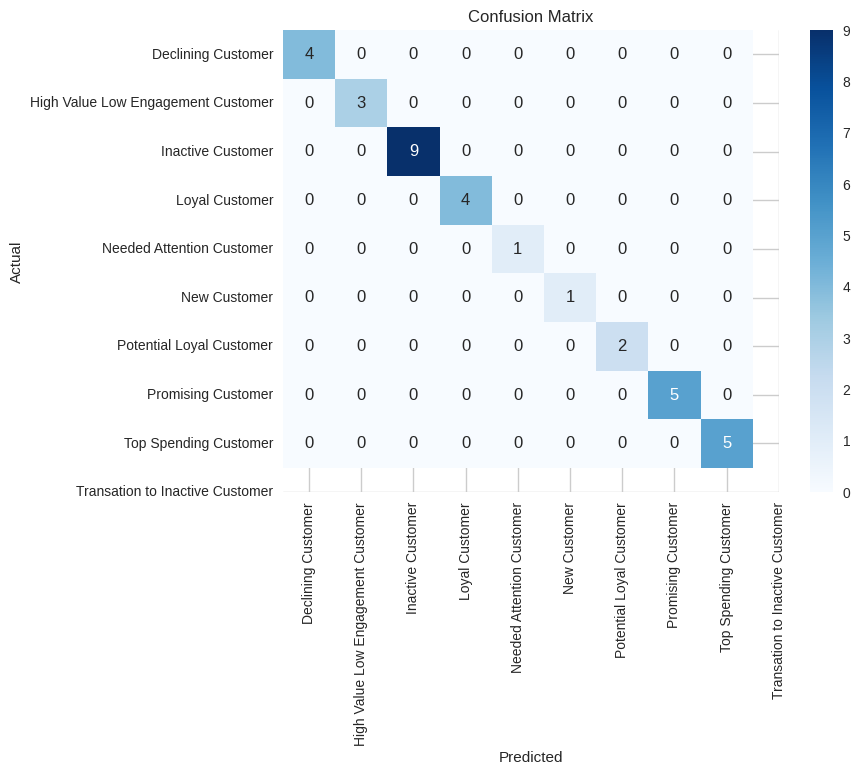

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
joblib.dump(model, 'svm_model.joblib')

['svm_model.joblib']

### Logistic Regression

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       1.00      1.00      1.00         3
           2       0.89      0.89      0.89         9
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       0.25      0.50      0.33         2
           8       0.60      0.60      0.60         5
           9       1.00      0.80      0.89         5

    accuracy                           0.79        34
   macro avg       0.83      0.81      0.81        34
weighted avg       0.84      0.79      0.81        34

Accuracy: 0.7941176470588235


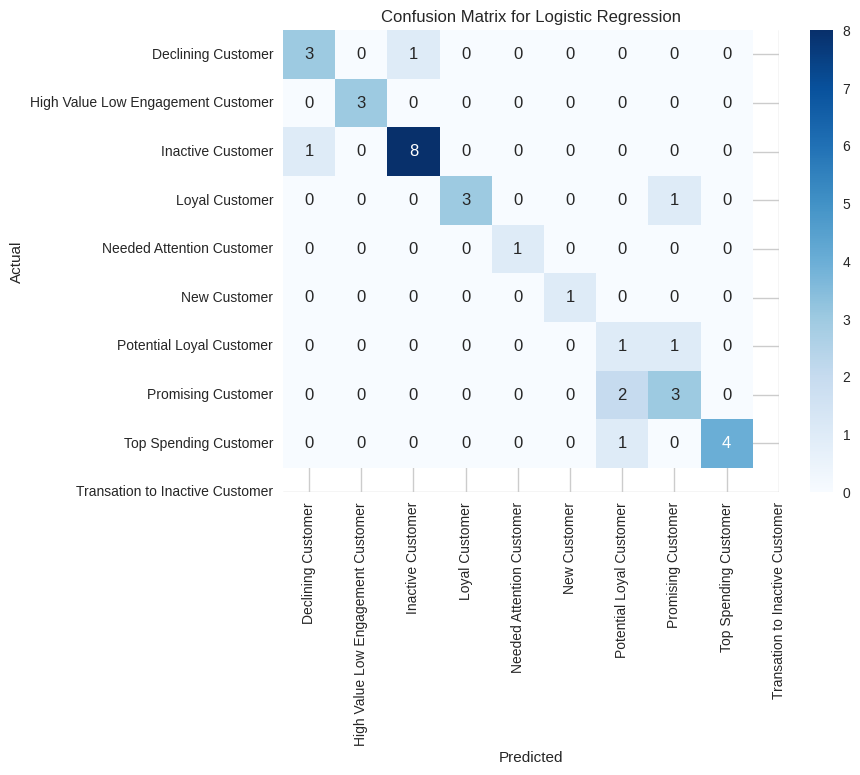

In [ ]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

y_pred_logreg = logreg_model.predict(X_test)

print(classification_report(y_test, y_pred_logreg))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))

cm_logreg = confusion_matrix(y_test, y_pred_logreg)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [ ]:
joblib.dump(logreg_model, 'logreg_model.joblib')

['logreg_model.joblib']

### Naive Bayes

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.67      0.80         3
           2       1.00      0.89      0.94         9
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      0.50      0.67         2
           8       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         5

    accuracy                           0.91        34
   macro avg       0.94      0.90      0.90        34
weighted avg       0.93      0.91      0.91        34

Accuracy: 0.9117647058823529


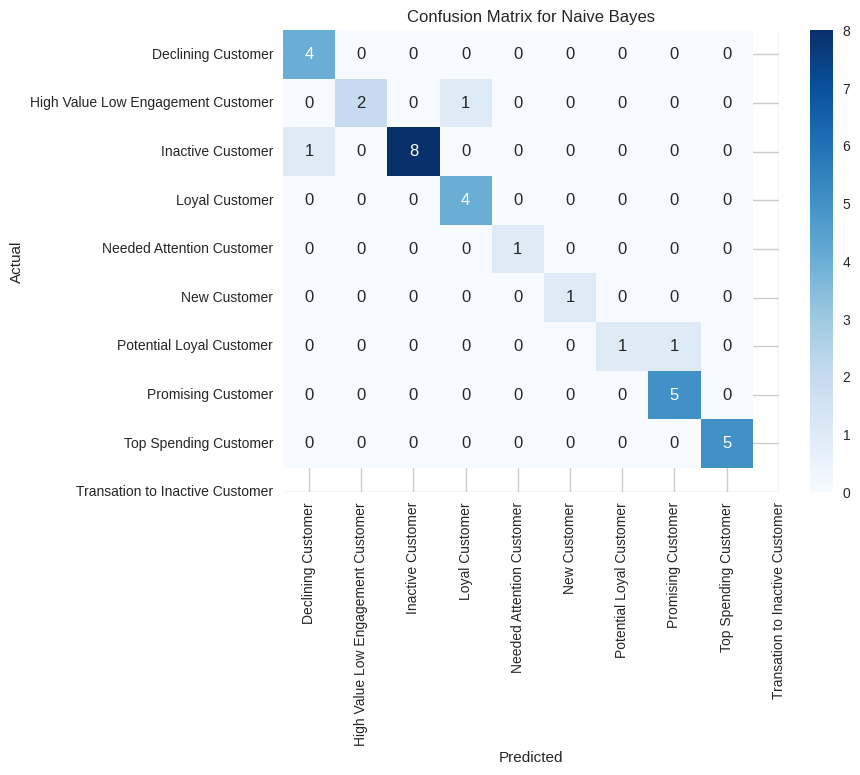

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

In [ ]:
joblib.dump(nb_model, 'naivebayes_model.joblib')

['naivebayes_model.joblib']

### Decision Tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34

Accuracy: 1.0


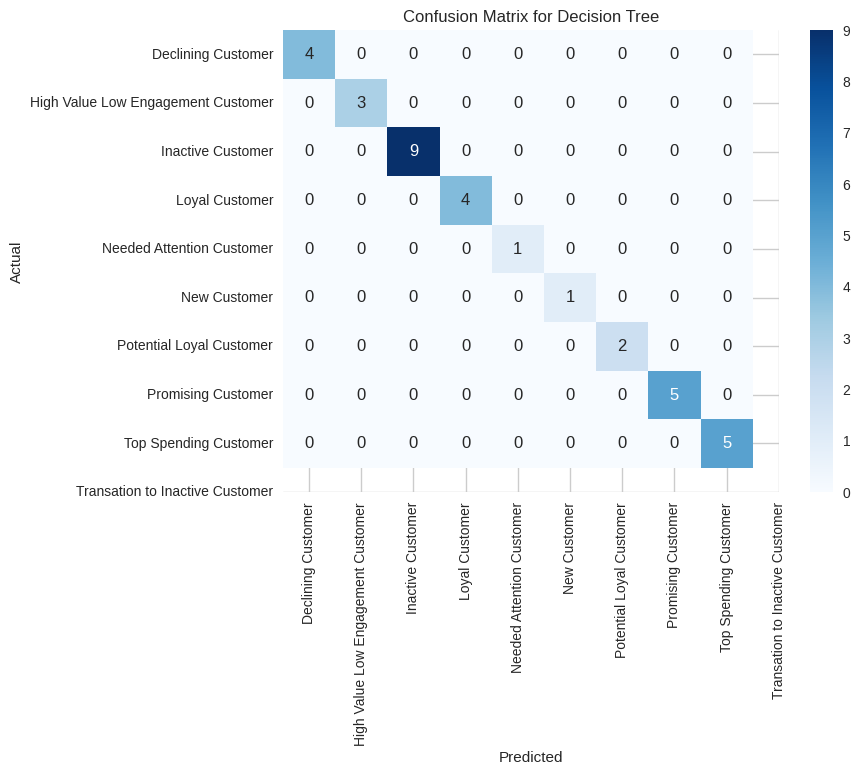

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)  # You can adjust hyperparameters
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print(classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

In [ ]:
joblib.dump(dt_model, 'dt_model.joblib')

['dt_model.joblib']

## Time Series

In [ ]:
data_encoder.head()

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
1392,4025,3,126.0,2022-10-02,1.5,0
2286,4108,13,50.0,2022-10-02,2.1,1
1250,4008,1,130.0,2022-10-02,3.4,1
3302,4093,13,24.0,2022-10-02,2.8,1
1704,4014,42,99.0,2022-10-02,1.2,0


In [ ]:
print("Min Date Purchase:", df['Date Purchase'].min())
print("Max Date Purchase:", df['Date Purchase'].max())

Min Date Purchase: 2022-10-02 00:00:00
Max Date Purchase: 2023-10-01 00:00:00


In [ ]:
data_encoder

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
1392,4025,3,126.0,2022-10-02,1.5,0
2286,4108,13,50.0,2022-10-02,2.1,1
1250,4008,1,130.0,2022-10-02,3.4,1
3302,4093,13,24.0,2022-10-02,2.8,1
1704,4014,42,99.0,2022-10-02,1.2,0
...,...,...,...,...,...,...
1433,4108,6,46.0,2023-10-01,1.8,0
1790,4029,24,151.0,2023-10-01,4.0,0
824,4005,48,122.0,2023-10-01,2.0,0
2944,4000,49,58.0,2023-10-01,2.6,1


In [ ]:
data_encoder = data_encoder.set_index('Date Purchase')
df_resampled = data_encoder.resample('D').agg({
    'Purchase Amount (USD)': 'sum',
    'Item Purchased': 'count',
    'Review Rating': 'mean',
    'Payment Method': lambda x: x.mode()[0] if not x.empty else None # Use lambda for mode to handle empty groups
})

In [ ]:
df_resampled

,Purchase Amount (USD),Item Purchased,Review Rating,Payment Method
Date Purchase,,,,
2022-10-02,822.0,7,2.385714,1
2022-10-03,929.0,12,2.632187,0
2022-10-04,1071.0,10,3.607250,0
2022-10-05,1160.0,12,3.065521,1
2022-10-06,411.0,4,3.650000,0
...,...,...,...,...
2023-09-27,338.0,4,3.500000,0
2023-09-28,840.0,8,3.087500,1
2023-09-29,604.0,6,2.783333,1


In [ ]:
train_data, test_data = train_test_split(df_resampled, test_size=0.2, shuffle=False)

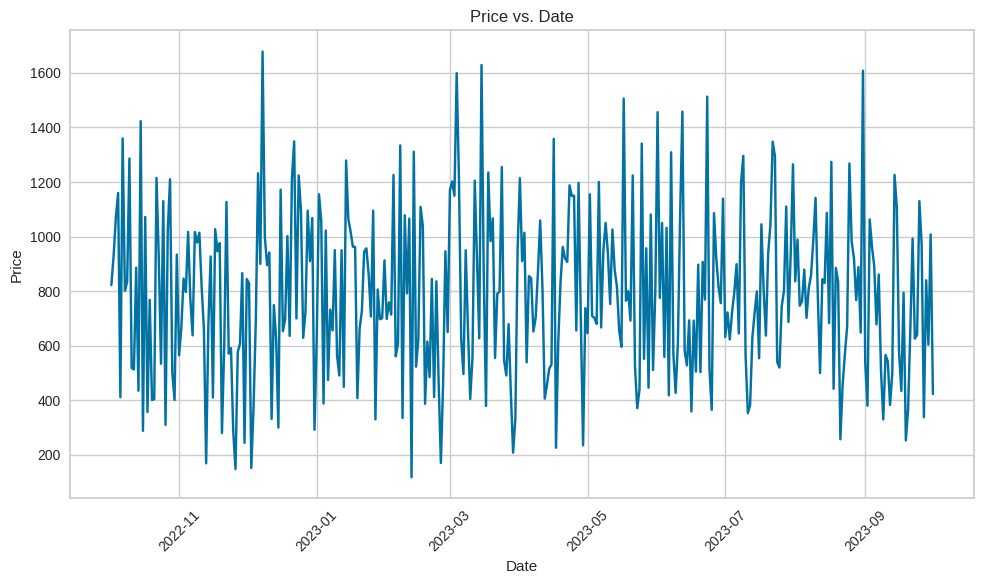

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_resampled['Purchase Amount (USD)'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price vs. Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
train_data, test_data = train_test_split(df_resampled, test_size=0.2, shuffle=False)

In [ ]:
model = SARIMAX(train_data['Purchase Amount (USD)'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results = model.fit()

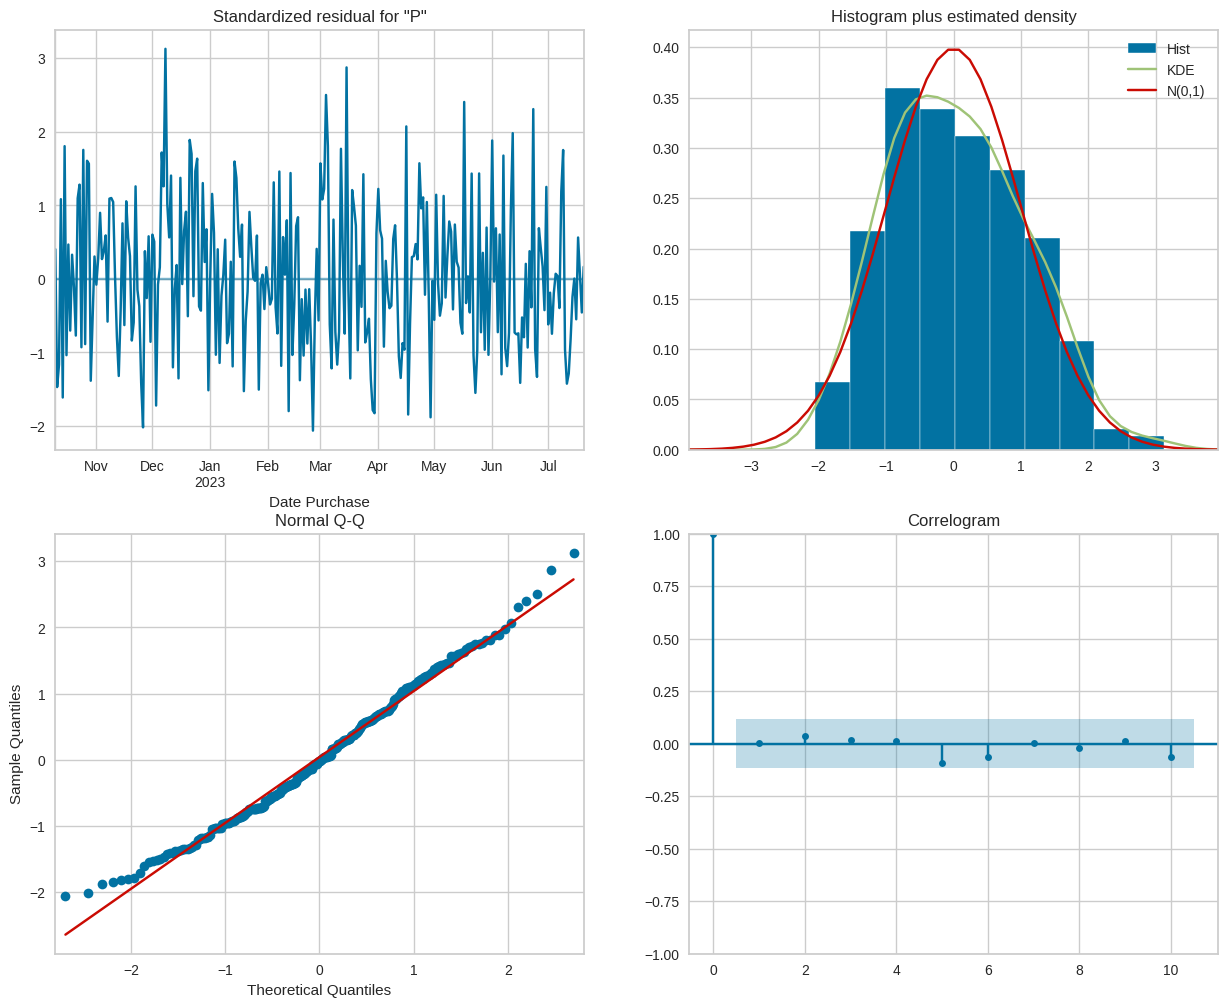

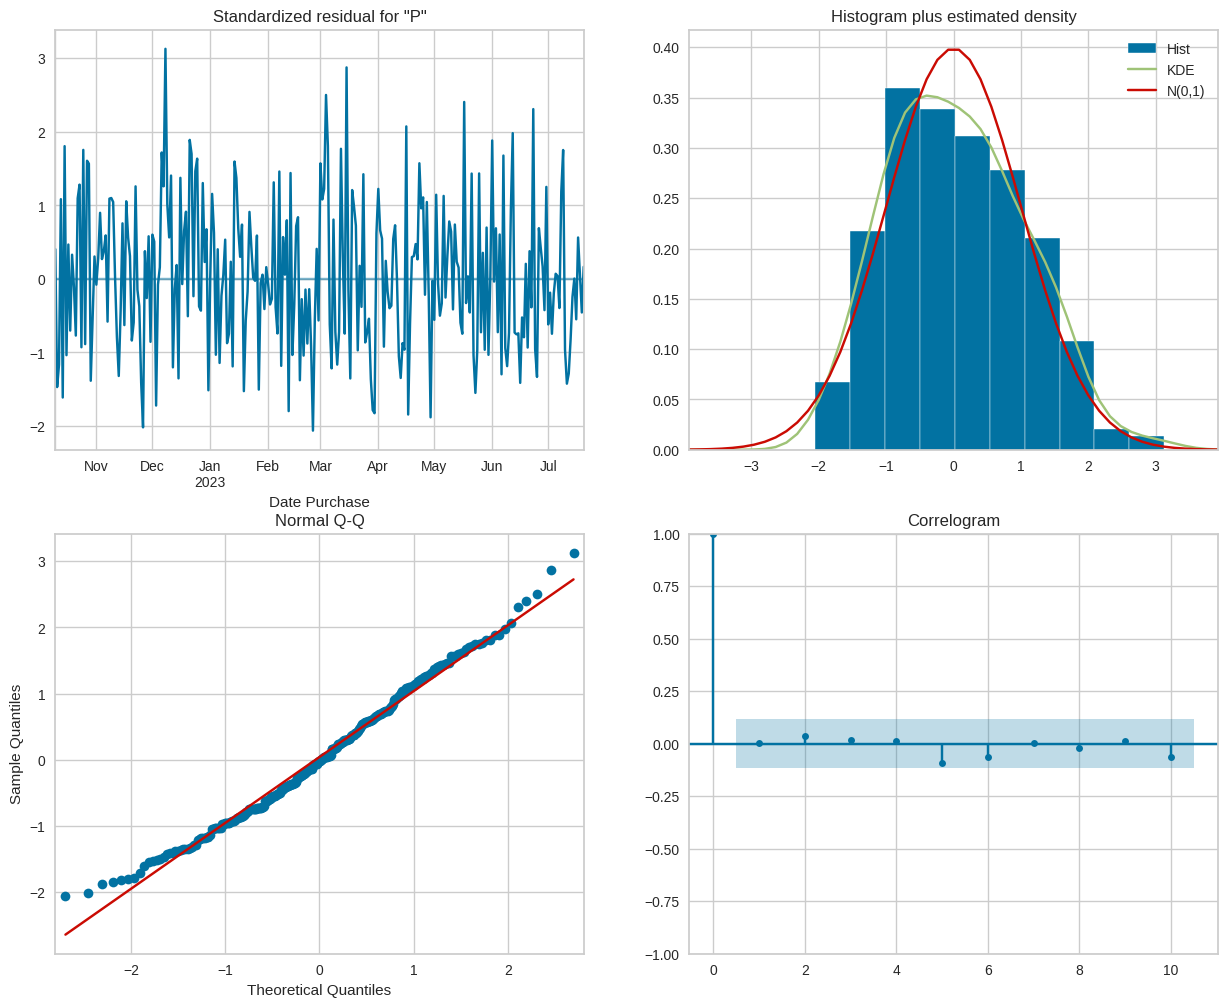

In [ ]:
results.plot_diagnostics(figsize=(15,12))

In [ ]:
predictions = results.get_forecast(steps=len(test_data))
predicted_mean = predictions.predicted_mean

rmse = np.sqrt(mean_squared_error(test_data['Purchase Amount (USD)'], predicted_mean))
print(f'RMSE: {rmse}')

RMSE: 279.91484328571846


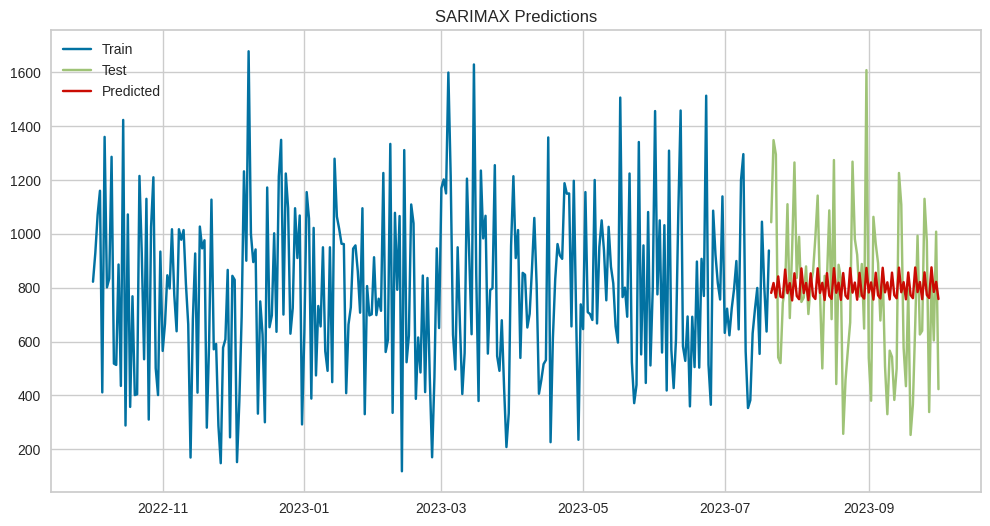

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Purchase Amount (USD)'], label='Train')
plt.plot(test_data['Purchase Amount (USD)'], label = 'Test')
plt.plot(predicted_mean, label = 'Predicted')
plt.legend()
plt.title('SARIMAX Predictions')
plt.show()

In [ ]:
def forecast(data, periods=2):
    train_data = data[-periods*30:]

    model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    results = model.fit()

    steps = periods * 30
    forecast_results = results.get_forecast(steps=steps)
    predicted_mean = forecast_results.predicted_mean
    confidence_intervals = forecast_results.conf_int()

    index_of_fc = pd.date_range(train_data.index[-1] + pd.DateOffset(months=1), periods = 1*30, freq='MS')

    fitted_series = pd.Series(results.fittedvalues, index=index_of_fc)  # Fitted values for training data
    lower_series = pd.Series(confidence_intervals.iloc[:, 0], index=index_of_fc)
    upper_series = pd.Series(confidence_intervals.iloc[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(data, color='#1f76b4', label='Actual')  # Plot the original data
    #plt.plot(fitted_series, color='darkgreen', label='Fitted')  # Plot the fitted values
    plt.plot(predicted_mean, color='red', label='Forecast')  # Plot the forecast
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Purchase Amount (USD)")
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



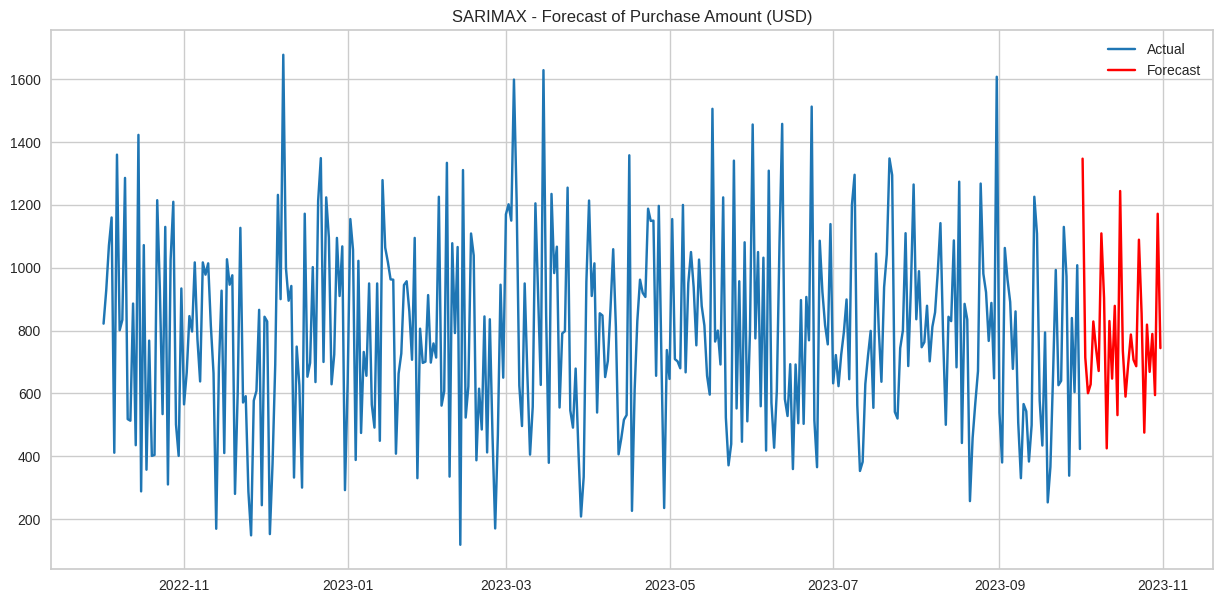

In [ ]:
forecast(df_resampled['Purchase Amount (USD)'], periods=1)

In [ ]:
joblib.dump(results, 'timeseries_sarimax_model.joblib')

['timeseries_sarimax_model.joblib']

# Collaborative Filtering

In [ ]:
df.head()

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method,Clusters
1392,4025,Blouse,126.0,2022-10-02,1.5,Cash,4
2286,4108,Handbag,50.0,2022-10-02,2.1,Credit Card,0
1250,4008,Belt,130.0,2022-10-02,3.4,Credit Card,0
3302,4093,Handbag,24.0,2022-10-02,2.8,Credit Card,0
1704,4014,Tank Top,99.0,2022-10-02,1.2,Cash,1


RMSE: 1.1334
Top 10 recommendations for user 4025:
Item: Cardigan, Estimated Rating: 3.13
Item: Coat, Estimated Rating: 2.95
Item: Coat, Estimated Rating: 2.95


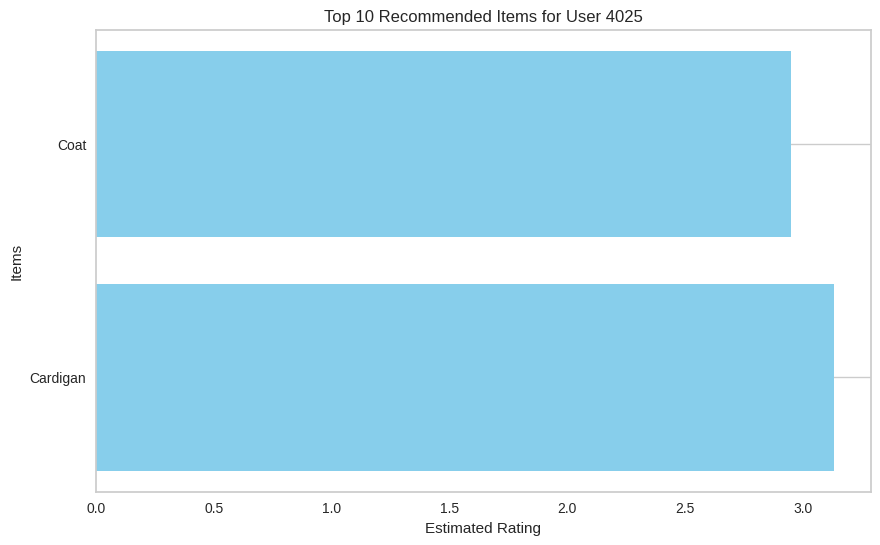

In [ ]:
# Collaborative Filtering
from surprise.model_selection import train_test_split
ratings_df = df[['Customer Reference ID', 'Item Purchased', 'Review Rating']]

# Menggunakan Surprise untuk mempersiapkan data
reader = Reader(rating_scale=(1, 5))  # Asumsikan rating antara 1 dan 5
data = Dataset.load_from_df(ratings_df, reader)

# Membagi data menjadi data latih dan data uji
trainset, testset = train_test_split(data, test_size=0.2)

# Membangun model SVD
model_cf = SVD()
model_cf.fit(trainset)

# Melakukan prediksi
predictions = model_cf.test(testset)

# Menghitung akurasi
accuracy.rmse(predictions)

# Menggunakan model untuk merekomendasikan item
def get_top_n(predictions, n=10):
    # Mengambil prediksi dan mengelompokkan berdasarkan user
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if not uid in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))

    # Mengurutkan item berdasarkan estimasi rating
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Mendapatkan 10 rekomendasi teratas untuk setiap user
top_n = get_top_n(predictions, n=10)

# Menampilkan rekomendasi untuk user pertama
user_id = ratings_df['Customer Reference ID'].unique()[0]
print(f'Top 10 recommendations for user {user_id}:')
for item, rating in top_n[user_id]:
    print(f'Item: {item}, Estimated Rating: {rating:.2f}')

# Visualisasi rekomendasi
recommended_items = [item for item, _ in top_n[user_id]]
recommended_ratings = [rating for _, rating in top_n[user_id]]

plt.figure(figsize=(10, 6))
plt.barh(recommended_items, recommended_ratings, color='skyblue')
plt.title(f'Top 10 Recommended Items for User {user_id}')
plt.xlabel('Estimated Rating')
plt.ylabel('Items')
plt.grid(axis='x')
plt.show()

In [ ]:
joblib.dump(model_cf, 'collaborativeFiltering_model.joblib')

['collaborativeFiltering_model.joblib']